TODO
- genomic data needs to be PCA and split up into train/val/data
- get rid of acc

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

# can revome the lines that need these
import os
import pickle

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import utils

from datasets import GeneralDataset
# import Transforms as myTransforms
from Transforms import get_transformations
from utils import get_data_splits, get_input_params

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Choose parameters
- 4 channel full resolution:
```python
    task \in ['idh', '1p19q']
    dataformat \in ['raw3D', 'crop3Dslice', 'modality3D']
    modality \in ['t1ce', 'flair', 't2', 't1', 't1ce-t1']
    mtl \in [True, False]
    include_genomic_data \in [True, False]
```

In [3]:
task = 'idh'
dataformat = 'crop3Dslice'
modality = 't1ce' # only relevent for 'modality3D' dataformat
mtl = True
include_genomic_data = False # don't include genomic data

null_genomic = not include_genomic_data

dataformat, channels, resize_shape = get_input_params(dataformat)

In [4]:
print('task:\t\t', task)
print('mtl:\t\t', mtl)
print('dataformat:\t', dataformat)
print('channels:\t', channels)
print('modality:\t', modality)
print('resize_shape:\t', resize_shape)
print('null_genomic:\t', null_genomic)

task:		 idh
mtl:		 True
dataformat:	 raw3D_mtl
channels:	 4
modality:	 t1ce
resize_shape:	 (144, 144, 144)
null_genomic:	 True


In [5]:
# MRI directory
image_dir = '../data/all_brats_scans/'

# metadata for all brats (including tcia) data
best_model_loc = '../pretrained/espnet_3d_brats.pth' # segmentation model weights
glioma_metadata_df = pd.read_csv('../data/glioma_metadata.csv', index_col=0) # metadata file
glioma_metadata_df.loc[['Brats18_TCIA09_462_1', 'Brats18_TCIA10_236_1'], 'idh'] = 1 ######

# get training splits
train_df, val_df, classes = get_data_splits(metadata_df=glioma_metadata_df, task=task, mtl=mtl)

# map between brats dataset and tcia data (tcia data is avalible for a subset of the brats patients)
brats2tcia_df = glioma_metadata_df['tciaID']
# brats2tcia_df = pd.read_csv('../../miccai_clean/data/brats2tcia_df_542x1.csv', index_col=0)

# these are labeled files (they were paths in old dataloader) but they are dataframes
labels_dict = {'train':train_df, 'val':val_df, 'data':glioma_metadata_df}

genomic_data_dict = {'train':'../data/MGL/MGL_235x50.csv', 'val':'../data/MGL/MGL_235x50.csv'}

label = task

print('Train size', len(train_df))

Train size 467


# 3D cropped

In [6]:
# def get_transformations2(channels, resize_shape, prob_voxel_zero=0.2, prob_true=0.8, prob_channel_zero=0.5):
    
    
#     if channels == 1:
#         # minimal data augmentation
#         train_transformations = myTransforms.Compose([
#                 myTransforms.MinMaxNormalize(),
#                 myTransforms.ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
#                                           interpolation=1,
#                                           channels=channels), # 1 is also channels
#                 myTransforms.ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
#                 myTransforms.RandomFlip(),
#                 myTransforms.ToTensor(),
#             ])

#         # segmentation masks have separate transformations (don't want to normalize)
#         seg_transformations = myTransforms.Compose([
#               myTransforms.ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]), 
#                                           interpolation=0, 
#                                           channels=channels),
#                 myTransforms.ToTensor(),
#             ])

#         val_transformations = myTransforms.Compose([
#                 myTransforms.MinMaxNormalize(),
#                 myTransforms.ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]), 
#                                           interpolation=1,
#                                           channels=channels),
#                 myTransforms.ToTensor(),
#             ])
#     elif channels == 4:
#         # minimal data augmentation
#         flip = myTransforms.RandomFlip()
#         train_transformations = myTransforms.Compose([
#                 myTransforms.MinMaxNormalize(),
#                 myTransforms.ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]), 
#                                           interpolation=1, 
#                                           channels=channels),
#                 myTransforms.ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
#                 myTransforms.ZeroChannel(prob_zero=prob_channel_zero), # with 4 sequences we set 1 to zero with some probabilty
# #                 myTransforms.RandomFlip(),
#                 flip,
#                 myTransforms.ToTensor(),
#             ])

#         seg_transformations = myTransforms.Compose([
#             myTransforms.ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]), 
#                                           interpolation=0, 
#                                           channels=1),
#             flip,
#                 myTransforms.ToTensor(),
#             ])


#         val_transformations = myTransforms.Compose([
#                 myTransforms.MinMaxNormalize(),
#                 myTransforms.ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]), 
#                                           interpolation=1, 
#                                           channels=channels),
#                 myTransforms.ToTensor(),
#             ])
#     return train_transformations, seg_transformations, val_transformations

In [7]:
# from Transforms import RandomFlip, Compose, MinMaxNormalize, ScaleToFixed, ZeroSprinkle, ZeroChannel, ToTensor

In [8]:
# def get_transformations(channels, resize_shape, prob_voxel_zero=0.2, prob_true=0.8, prob_channel_zero=0.5, mtl=False):
#     '''
#     This function performs data basic augmentation
#     Arguments
#     ---------
#     channels: number of MRI sequences in input (1 or 4)
#     resize_shape: new dimensions for each MRI input sequences
#     prob_voxel_zero: probabiltiy that we set any voxel to zero (conditioned on prob_true)
#     prob_true: probability that we set any voxels to zero
#     prob_channel_zero: probablity that a random sample is set to zero (only used with 4-channel input)

#     Outputs
#     ---------
#     train_transformations: augmented training data
#     seg_transformations: augmented segmentation labels
#     val_transformations: augmented validation data
#     '''
    
#     if channels == 1:
#         # with 4 sequences we set 1 channel to zero with some probabilty
#         # but with 1 sequence we set 1 channel to zero with zero probabilty
#         prob_channel_zero = 0
#     if mtl:
#         randomflip = RandomFlip(prob_flip=0)
#     else:
#         randomflip = RandomFlip()

#     # minimal data augmentation
#     train_transformations = Compose([
#             MinMaxNormalize(),
#             ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
#                                       interpolation=1,
#                                       channels=channels),
#             ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
#             ZeroChannel(prob_zero=prob_channel_zero),
#             randomflip,
#             ToTensor(),
#         ])

#     seg_transformations = Compose([
#             ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]),
#                                       interpolation=0,
#                                       channels=1),
#             randomflip,
#             ToTensor(),
#         ])


#     val_transformations = Compose([
#             MinMaxNormalize(),
#             ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
#                                       interpolation=1,
#                                       channels=channels),
#             ToTensor(),
#         ])
#     return train_transformations, seg_transformations, val_transformations

In [7]:
# batch size
train_transformations, seg_transformations, val_transformations = get_transformations(channels=channels, 
                                                                                      resize_shape=resize_shape, 
                                                                                      prob_voxel_zero=0.2, 
                                                                                      prob_true=0.8, 
                                                                                      prob_channel_zero=0.5,
                                                                                      mtl=mtl)

transformed_dataset_train = GeneralDataset(csv_file=train_df, ## change this from "csv_file"
                                           root_dir=image_dir,
                                           genomic_csv_file = genomic_data_dict['train'],
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           label=label,
                                           classes=classes,
                                           dataformat=dataformat,
                                           returndims=resize_shape,
                                           brats2tcia_df=brats2tcia_df,
                                           null_genomic = null_genomic,
                                           pretrained=best_model_loc,
                                           modality=modality)

transformed_dataset_val = GeneralDataset(csv_file=val_df,
                                         root_dir=image_dir,
                                         genomic_csv_file = genomic_data_dict['val'],
                                         transform=val_transformations,
                                         seg_transform=seg_transformations,
                                         label=label,
                                         classes=classes,
                                         dataformat=dataformat,
                                         returndims=resize_shape,
                                         brats2tcia_df=brats2tcia_df,
                                         null_genomic = null_genomic,
                                         pretrained=best_model_loc,
                                         modality=modality)


image_datasets = {'train':transformed_dataset_train, 'val':transformed_dataset_val}

train_batch_size, val_batch_size = 4, 4
dataloader_train = DataLoader(image_datasets['train'], batch_size=train_batch_size, shuffle=True, num_workers=4)
dataloader_val = DataLoader(image_datasets['val'], batch_size=val_batch_size, shuffle=True, num_workers=4)

dataloaders = {'train':dataloader_train, 'val':dataloader_val}
dataset_sizes = {'train':len(image_datasets['train']), 'val':len(image_datasets['val'])}

class_names = image_datasets['train'].classes
class_names

['wildtype', 'mutant']

Brats18_TCIA11_612_1


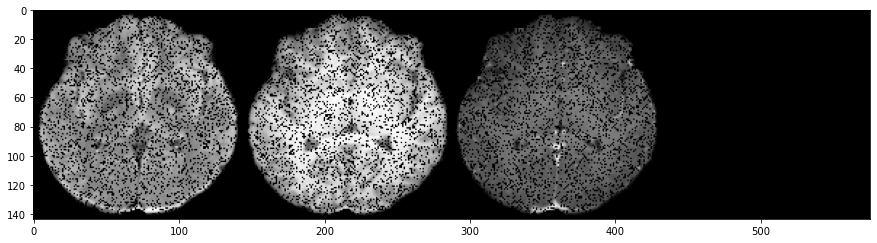

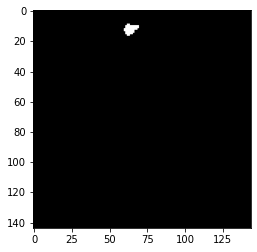

In [17]:
# visulize training (or validation) data
for i, data in enumerate(dataloaders['train']):
    # data batch
    (image, seg_image, genomic_data, seg_probs), label, (OS, OS_EVENT), bratsID = data
    # print scan ID
    print(bratsID[0])
    
    # format MRI images (slices of volumetric input)
    img = image[0,:, :, :, int(image.shape[-1]/2)].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()
    
    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()

    ## plot segmentation mask ##
    seg_img = seg_image[0, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    plt.show()

    break

In [22]:
seg_img.shape

(3, 144, 144)

In [17]:
image.shape

torch.Size([4, 4, 144, 144, 144])

In [15]:
from torch.utils.tensorboard import SummaryWriter
img_dims = str(resize_shape[0]) + 'x' + str(resize_shape[1]) + 'x' + str(resize_shape[2])
model_outfile_dir = '3D_' + task + '_' + modality+'_mtl-' + str(mtl) + '_' \
                    + img_dims + '_genomic-' + str(include_genomic_data)
print('tensorboad:', model_outfile_dir)
writer = SummaryWriter('runs1/'+model_outfile_dir)

tensorboad: 3D_idh_t1ce_mtl-True_64x64x64_genomic-False


In [12]:
# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [15]:
num_classes = 2

label_df = train_df.loc[train_df[task].isin([0,1])][task]
_, cnts = np.unique(label_df, return_counts=True)
loss_weights = (np.ones(num_classes)/cnts)*np.max(cnts)
loss_weights = torch.FloatTensor(loss_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=loss_weights)
print('loss weights:', loss_weights)

loss weights: tensor([1.0364, 1.0000], device='cuda:0')


In [16]:
best_auc_list, best_acc_list, best_auc_acc_list = [], [], []
epochs = 50
iterations = 10
    
if not mtl:
    print('no mtl')
    from train import train
    if channels == 1:
        for i in range(iterations):
            print('Iteration', i)

            from models.Models import SegModel

            esp_model = SegModel(best_model_loc=best_model_loc, 
                                 inp_res = resize_shape, 
                                 num_classes=num_classes, 
                                 channels=4)

            level0_weight = esp_model.espnet.level0.conv.weight[:, 0].unsqueeze(1)
            esp_model.espnet.level0.conv = nn.Conv3d(1, 16, kernel_size=(7, 7, 7), 
                                                     stride=(2, 2, 2), padding=(3, 3, 3), bias=False)

            esp_model.espnet.level0.conv.weight = nn.Parameter(level0_weight)
            esp_model = esp_model.to(device=device)

            optimizer_esp = optim.Adam(esp_model.parameters(), lr=0.0005) # change to adam
        #     exp_scheduler = optim.lr_scheduler.StepLR(optimizer_esp, step_size=7, gamma=0.1)

            exp_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_esp, 
                                                                 mode='min', 
                                                                 factor=0.1, 
                                                                 patience=10, # number of epochs with no change 
                                                                 verbose=True, 
                                                                 threshold=0.0001, 
                                                                 threshold_mode='rel', 
                                                                 cooldown=0, 
                                                                 min_lr=0, 
                                                                 eps=1e-08)


            model, best_wts, best_auc, best_acc, best_auc_acc = train(model=esp_model, 
                               dataloaders=dataloaders,
                               data_transforms=data_transforms,
                               criterion = criterion, 
                               optimizer=optimizer_esp, 
                               scheduler=exp_scheduler,
                               writer=writer,
                               num_epochs=epochs, 
                               verbose=False, 
                               device=device,
                               dataset_sizes=dataset_sizes,
                               channels=1,
                               resize_shape=resize_shape,
                               classes=class_names,
                               volume_val=False,
                               weight_outfile_prefix=model_outfile_dir)
            del esp_model
            del model

            best_auc_list.append(best_auc)
            best_acc_list.append(best_acc)
            best_auc_acc_list.append(best_auc_acc)


            if not os.path.exists('../model_weights/results/'):
                os.makedirs('../model_weights/results/')

            results_outfile_dir = model_outfile_dir + '_epochs-' + str(epochs) +'_iterations-' + str(iterations)
            with open('../model_weights/results/auc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_auc_list, fp)
            with open('../model_weights/results/acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_acc_list, fp)
            with open('../model_weights/results/avg_auc_acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_auc_acc_list, fp)
                
    elif channels == 4:
        criterion = nn.CrossEntropyLoss(weight=loss_weights)
        for i in range(iterations):
            print('Iteration', i)
            from models.Models import SegModel
            esp_model = SegModel(best_model_loc=best_model_loc, inp_res = resize_shape, num_classes=num_classes)

            if channels == 1:
                level0_weight = esp_model.espnet.level0.conv.weight[:, 0].unsqueeze(1)
                esp_model.espnet.level0.conv = nn.Conv3d(1, 16, kernel_size=(7, 7, 7), 
                                                         stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
                esp_model.espnet.level0.conv.weight = nn.Parameter(level0_weight)



            esp_model = esp_model.to(device=device)

            optimizer_esp = optim.Adam(esp_model.parameters(), lr=0.0005) # change to adam
            exp_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_esp, 
                                                                 mode='min', 
                                                                 factor=0.1, 
                                                                 patience=10, # number of epochs with no change 
                                                                 verbose=True, 
                                                                 threshold=0.0001, 
                                                                 threshold_mode='rel', 
                                                                 cooldown=0, 
                                                                 min_lr=0, 
                                                                 eps=1e-08)


            
            model, best_wts, best_auc, best_acc, best_auc_acc = train(model=esp_model, 
                               dataloaders=dataloaders,
                               data_transforms=data_transforms,
                               criterion = criterion, 
                               optimizer=optimizer_esp, 
                               scheduler=exp_scheduler,
                               writer=writer,
                               num_epochs=epochs, 
                               verbose=False, 
                               device=device,
                               dataset_sizes=dataset_sizes,
                               channels=1,
                               resize_shape=resize_shape,
                               classes=class_names,
                               weight_outfile_prefix=model_outfile_dir)
            del esp_model
            del model

            best_auc_list.append(best_auc)
            best_acc_list.append(best_acc)
            best_auc_acc_list.append(best_auc_acc)


            results_outfile_dir = model_outfile_dir + '_epochs-' + str(epochs) +'_iterations-' + str(iterations)

            if not os.path.exists('../model_weights/results/'):
                os.makedirs('../model_weights/results/')

            with open('../model_weights/results/auc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_auc_list, fp)

            with open('../model_weights/results/acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_acc_list, fp)

            with open('../model_weights/results/avg_auc_acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
                pickle.dump(best_auc_acc_list, fp)
            


In [ ]:
if mtl:
    print('mtl')
    seg_loss_weight = 1
    surv_loss_weight = 1
    

    brats_seg_ids = glioma_metadata_df[glioma_metadata_df['gt_seg'] == 1].index

    seg_4class_weights = np.load('../data/segmentation_notcropped_4-class_weights.npy')
    seg_4class_weights = torch.FloatTensor(seg_4class_weights).to(device)
    print('seg_4class_weights:', seg_4class_weights)

    seg_2class_weights = np.load('../data/segmentation_notcropped_2-class_weights.npy')
    seg_2class_weights = torch.FloatTensor(seg_2class_weights).to(device)
    print('seg_2class_weights:', seg_2class_weights)
    
    
    for i in range(iterations):
        print('Iteration', i)


        from models.nick_mtl_model import GBMNetMTL
        gbm_net = GBMNetMTL(g_in_features=50, 
                            g_out_features=128, 
                            n_classes=num_classes, 
                            n_volumes=channels, 
                            seg_classes=4, 
                            pretrained=best_model_loc, 
                            class_loss_weights = loss_weights,
                            seg_4class_weights=seg_4class_weights,
                            seg_2class_weights=seg_2class_weights,
                            seg_loss_scale=seg_loss_weight,
                            surv_loss_scale=surv_loss_weight,
                            device = device,
                            brats_seg_ids=brats_seg_ids,
                            standard_unlabled_loss=False,
                            fusion_net_flag=True,
                            modality=modality,
                            take_surv_loss=False)
        gbm_net = gbm_net.to(device)

        optimizer_gbmnet = optim.Adam(gbm_net.parameters(), lr=0.0005) # change to adami
 
        exp_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_gbmnet, 
                                                             mode='min', 
                                                             factor=0.1, 
                                                             patience=10, # number of epochs with no change 
                                                             verbose=True, 
                                                             threshold=0.0001, 
                                                             threshold_mode='rel', 
                                                             cooldown=0, 
                                                             min_lr=0, 
                                                             eps=1e-08)

        from train_mtl import train
        model, best_wts, best_auc, best_acc, best_auc_acc = train(model=gbm_net, 
                       dataloaders=dataloaders,
                       data_transforms=data_transforms,
                       optimizer=optimizer_gbmnet, 
                       scheduler=exp_scheduler,
                       writer=writer,
                       num_epochs=epochs, 
                       verbose=False, 
                       device=device,
                       dataset_sizes=dataset_sizes,
                       channels=channels,
                       classes=class_names,
                       weight_outfile_prefix=model_outfile_dir,
                       pad=0)


        del gbm_net
        del model

        best_auc_list.append(best_auc)
        best_acc_list.append(best_acc)
        best_auc_acc_list.append(best_auc_acc)

        if not os.path.exists('../model_weights/results/'):
            os.makedirs('../model_weights/results/')

        results_outfile_dir = model_outfile_dir + '_epochs-' + str(epochs) +'_iterations-' + str(iterations)
        with open('../model_weights/results/auc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
            pickle.dump(best_auc_list, fp)
        with open('../model_weights/results/acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
            pickle.dump(best_acc_list, fp)
        with open('../model_weights/results/avg_auc_acc_' + results_outfile_dir + '.txt', "wb") as fp:   #Pickling
            pickle.dump(best_auc_acc_list, fp)

mtl
seg_4class_weights: tensor([  1.0000, 124.3847,  60.4277, 188.0025], device='cuda:0')
seg_2class_weights: tensor([ 1.0000, 33.4366], device='cuda:0')
Iteration 0
GBMNet!
training . . . 


  0%|          | 0/50 [00:00<?, ?it/s]

before epochs
  >> val_loss 0.4125611681049153 epoch 0
  >> val AUC  0.525462962962963 | mean acc auc 0.5127314814814815 | acc 0.5 | epoch 0
New Best AUC-acc average:	 0.5127314814814815 	in epoch 0
New Best Dice:	 0.23227348962856056 	in epoch 0
New Best ACC:	 0.5 	in epoch 0


  2%|▏         | 1/50 [12:07<9:54:27, 727.90s/it]

New Best AUC-acc average:	 0.5199652777777778 	in epoch 1


  4%|▍         | 2/50 [24:14<9:42:04, 727.58s/it]

  >> val_loss 0.4241721973580829 epoch 2
  >> val AUC  0.48726851851851855 | mean acc auc 0.4936342592592593 | acc 0.5 | epoch 2
New Best Dice:	 0.3413010238773681 	in epoch 2


  6%|▌         | 3/50 [36:21<9:29:46, 727.37s/it]

# need to combine
- nick_mtl_model
- train_mtl
- joint_model2

### 